In [1]:
!pip install geopandas
!pip install arcgis
!pip install geocoder

     |████████████████████████████████| 994 kB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 24.2 MB/s 
     |████████████████████████████████| 15.4 MB 84 kB/s 
     |████████████████████████████████| 3.4 MB 5.1 MB/s 
  Using cached keyring-23.2.1-py3-none-any.whl (33 kB)
  Using cached lerc-0.1.0-py3-none-any.whl
  Using cached ujson-4.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (214 kB)
  Using cached jupyterlab-3.1.14-py3-none-any.whl (8.5 MB)
  Using cached python_certifi_win32-1.6-py2.py3-none-any.whl (7.2 kB)
  Using cached pyshp-2.1.3-py3-none-any.whl
  Using cached requests_toolbelt-0.9.1-py2.py3-none-any.whl (54 kB)
  Using cached requests_ntlm-1.1.0-py2.py3-none-any.whl (5.7 kB)
  Using cached SecretStorage-3.3.1-py3-none-any.whl (15 kB)
  Using cached jeepney-0.7.1-py3-none-any.whl (54 kB)
  Using cached cryptography-3.4.8-cp36-abi3-manylinux_2_24_x86_64.whl (3.0 MB)
  Using cached jupyter_server-1.11.0-py3-none-any.whl (393 kB)
  Using cached nb

     |████████████████████████████████| 98 kB 3.8 MB/s 


In [2]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import time
import os 
from os import path
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import statsmodels.api as sm
import bs4 as bs
from geopy.geocoders import Nominatim
import geopandas as gpd
import seaborn as sns
from scipy import stats


# To make pyproj conversions work


Consolidate scraped data

In [ ]:
df0 = pd.read_csv("/content/drive/MyDrive/toronto_condos/realmaster1000.csv")
df1 = pd.read_csv("/content/drive/MyDrive/toronto_condos/realmaster1714.csv")

df = pd.concat([df0, df1])
df.head()

Price               Location  ... Balcony       Square feet
0    $925,000 Sold  401 330 Adelaide St E  ...    Open    | 900-999 sqft
1    $630,000 Sold      2009 5 Soudan Ave  ...    Open    | 500-599 sqft
2    $812,000 Sold         3603 8 York St  ...    Open    | 700-799 sqft
3    $830,000 Sold        3606 85 Wood St  ...    Open    | 600-699 sqft
4  $2,360,000 Sold        4305 311 Bay St  ...    None  | 2000-2249 sqft

[5 rows x 8 columns]

Data cleaning and processing

In [ ]:
#Eliminate rows which don't have an address

df = df.dropna()
df = df.drop_duplicates()
print(len(df))
print(df.info())

1704
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 0 to 713
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        1704 non-null   object 
 1   Location     1704 non-null   object 
 2   Floor        1704 non-null   object 
 3   Bedrooms     1704 non-null   object 
 4   Bathrooms    1704 non-null   float64
 5   Parking      1704 non-null   object 
 6   Balcony      1704 non-null   object 
 7   Square feet  1704 non-null   object 
dtypes: float64(1), object(7)
memory usage: 119.8+ KB
None


In [ ]:
import re
from sklearn import preprocessing

def min_sqft(s):
    dash = s.index('-')
    low = int(s[:dash])
    high = int(s[dash+1:])
    return low

def max_sqft(s):
    dash = s.index('-')
    low = int(s[:dash])
    high = int(s[dash+1:])
    return high

def base_parking(s):
    try:
        p = s.index('+')
        base = int(s[:p])
        return base
    except:
        return int(s[0])

def add_parking(s):
    try:
        p = s.index('+')
        bra = s.index('(')
        add = int(s[p+1:bra])
        return add
    except:
        return 0

ohe = preprocessing.OneHotEncoder(sparse=False)

#Replace price column by numerical values
df['Price'] = df['Price'].apply(lambda a: str(a).replace('$', '').replace('Sold', '').replace(',', '')).astype('int64')
df['Bedrooms'] = df['Bedrooms'].apply(lambda a: str(a).replace('+1', '').replace('+2', '')).astype('float64')

#One-hot encode the balcony category
transformed = ohe.fit_transform(df['Balcony'].to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(transformed, columns=ohe.get_feature_names())
df.reset_index(drop=True, inplace=True)
ohe_df.reset_index(drop=True, inplace=True)
df = pd.concat([df, ohe_df], axis=1).drop(['Balcony'], axis=1)

df['base_parking'] = df['Parking'].apply(lambda a: base_parking(str(a).replace('|', '').replace('sqft', '')))
df['addition_parking'] = df['Parking'].apply(lambda a: add_parking(str(a).replace('|', '').replace('sqft', '')))

df['Min square feet'] = df['Square feet'].apply(lambda a: min_sqft(str(a).replace('|', '').replace('sqft', '')))
df['Max square feet'] = df['Square feet'].apply(lambda a: max_sqft(str(a).replace('|', '').replace('sqft', '')))
df.head()

Price               Location  ... Min square feet  Max square feet
0   925000  401 330 Adelaide St E  ...             900              999
1   630000      2009 5 Soudan Ave  ...             500              599
2   812000         3603 8 York St  ...             700              799
3   830000        3606 85 Wood St  ...             600              699
4  2360000        4305 311 Bay St  ...            2000             2249

[5 rows x 16 columns]

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             1704 non-null   int64  
 1   Location          1704 non-null   object 
 2   Floor             1704 non-null   object 
 3   Bedrooms          1704 non-null   float64
 4   Bathrooms         1704 non-null   float64
 5   Parking           1704 non-null   object 
 6   Square feet       1704 non-null   object 
 7   x0_Encl           1704 non-null   float64
 8   x0_Jlte           1704 non-null   float64
 9   x0_None           1704 non-null   float64
 10  x0_Open           1704 non-null   float64
 11  x0_Terr           1704 non-null   float64
 12  base_parking      1704 non-null   int64  
 13  addition_parking  1704 non-null   int64  
 14  Min square feet   1704 non-null   int64  
 15  Max square feet   1704 non-null   int64  
dtypes: float64(7), int64(5), object(4)
memory 

Get neighborhood and geodata for Toronto

In [4]:
t_geodata = gpd.read_file('/content/drive/MyDrive/toronto_condos/Neighbourhoods.geojson')
t_geodata_columns = pd.read_csv('/content/drive/MyDrive/toronto_condos/Neighbourhoods.csv')

# Convert data to lat, long type
t_geodata['geometry'] = t_geodata['geometry'].to_crs({'init': 'EPSG:4269'})
t_geodata.head()

_id  ...                                           geometry
0  11481  ...  POLYGON ((-79.41469 43.67391, -79.41485 43.674...
1  11482  ...  POLYGON ((-79.39414 43.66872, -79.39588 43.668...
2  11483  ...  POLYGON ((-79.46021 43.68156, -79.46044 43.681...
3  11484  ...  POLYGON ((-79.31485 43.66674, -79.31660 43.666...
4  11485  ...  POLYGON ((-79.41096 43.70408, -79.41165 43.703...

[5 rows x 18 columns]

In [5]:
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar

#Read data to json.
t_geodata_json = json.loads(t_geodata.to_json())

#Convert to String like object.
json_data = json.dumps(t_geodata_json)

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

p = figure(title = 'GTA neighbourhoods', plot_height = 600 , plot_width = 950)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,
          line_color = 'white', line_width = 0.25, fill_alpha = 1)

#Display figure in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

In [6]:
#get Toronto neighbourhood data and extract district codes with their average incomes
t_data = pd.read_csv('/content/drive/MyDrive/toronto_condos/neighbourhood-profiles-2016-csv.csv', )
# Potential Income prospects, ids: 1030, 2273, 2274
t_stats = t_data[(t_data.Characteristic == 'Neighbourhood Number') | 
                  (t_data.Characteristic == 'Total income: Average amount ($)') |
                  (t_data.Characteristic == 'Unemployment rate') |
                  (t_data.Characteristic == 'Population density per square kilometre')]
print(t_stats.head())                  
t_stats = t_stats.T.reset_index()
t_stats.columns = ['area', 'area_code', "pop_density", "unemployment_rate", 'average_income']
t_stats = t_stats.iloc[6:,:]
print(t_stats.head())
print('-' * 60)
#Looks like we need to convert income and area code columns into integers
print(t_stats.info())
print('-' * 60)
t_stats['average_income'] = t_stats['average_income'].apply(lambda a: a.replace(',','')).astype('int64')
t_stats['pop_density'] = t_stats['pop_density'].apply(lambda a: a.replace(',','')).astype('int64')
t_stats['unemployment_rate'] = t_stats['unemployment_rate'].astype('float64')
t_stats['area_code'] = t_stats['area_code'].astype('int64')
print(t_stats.info())
print('-' * 60)
# Calculate income mean
mean_t_income = t_stats['average_income'].mean()
print('GTA mean income: ',mean_t_income)

       _id  ... Yorkdale-Glen Park
0        1  ...                 31
7        8  ...              2,451
1890  1891  ...                  8
2272  2273  ...             38,527

[4 rows x 146 columns]
                            area area_code  ... unemployment_rate average_income
6                Agincourt North       129  ...               9.8         30,414
7   Agincourt South-Malvern West       128  ...               9.8         31,825
8                      Alderwood        20  ...               6.1         47,709
9                          Annex        95  ...               6.7        112,766
10             Banbury-Don Mills        42  ...               7.2         67,757

[5 rows x 5 columns]
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 6 to 145
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   area               140 non-nu

Merge geolocation data with neighborhood profile data

In [7]:
all_t_data = t_geodata.merge(t_stats, left_on='AREA_SHORT_CODE', right_on='area_code')
useless_columns_all_t_data = ['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE', 'AREA_LONG_CODE',
                             'AREA_NAME', 'AREA_DESC', 'X', 'Y']
all_t_data.drop(useless_columns_all_t_data, axis=1, inplace=True)
all_t_data.head()

LONGITUDE LATITUDE  OBJECTID  ...  pop_density  unemployment_rate average_income
0      None     None  17545105  ...         5683                6.6         165047
1      None     None  17545121  ...        10863                6.7         112766
2      None     None  17545137  ...         6464                7.2          35112
3      None     None  17545153  ...         7838                7.7          55199
4      None     None  17545169  ...         4685                7.5         169203

[5 rows x 13 columns]

Load Google Geodata API 

In [ ]:
import requests 
import geocoder
API_KEY = '' #You will need to get your own API key here

base = 'https://maps.googleapis.com/maps/api/geocode/json?'

def getCoords(address):
    #address = 'Bay Street / Wellesley Street West, Toronto, ON, Canada'
    params = {'key': API_KEY, 'address': address}

    response = requests.get(base, params)
    response = response.json()

    if response['status'] == 'OK':
        geometry = response['results'][0]['geometry']
        lat = geometry['location']['lat']
        lng = geometry['location']['lng']
        print("Address: " + address)
        print("Latitude: {}, Longitude: {}".format(lat, lng))
        return lat, lng
    return -1, -1


In [ ]:
#Add two columns containing latitiude and longitude coordinates for each listing

df['Latitude'], df['Longitude'] = zip(*df['Location'].apply(lambda addr: getCoords(addr)))
df.head()

Address: 401 330 Adelaide St E
Latitude: 43.6522018, Longitude: -79.3691271
Address: 2009 5 Soudan Ave
Latitude: 43.70436979999999, Longitude: -79.3971126
Address: 3603 8 York St
Latitude: 43.6405112, Longitude: -79.3811972
Address: 3606 85 Wood St
Latitude: 43.66279, Longitude: -79.379256
Address: 4305 311 Bay St
Latitude: 43.6498228, Longitude: -79.38022
Address: 1105 15 Legion Rd
Latitude: 43.6214794, Longitude: -79.483972
Address: 1509 3091 Dufferin St
Latitude: 43.7153135, Longitude: -79.45461900000001
Address: 1806 3 Massey Sq
Latitude: 43.6969025, Longitude: -79.29329539999999
Address: 601 2460 Eglinton Ave E
Latitude: 43.7342567, Longitude: -79.26289489999999
Address: 602 1030 King St W
Latitude: 43.6415839, Longitude: -79.41590939999999
Address: 805 20 Bloorview Pl
Latitude: 43.7744155, Longitude: -79.35878799999999
Address: 1010 80 Mill St
Latitude: 43.6513423, Longitude: -79.3581736
Address: 2202 1 The Espl
Latitude: 43.64580910000001, Longitude: -79.37568189999999
Address: 

Price               Location Floor  ...  Max square feet   Latitude  Longitude
0   925000  401 330 Adelaide St E     4  ...              999  43.652202 -79.369127
1   630000      2009 5 Soudan Ave    14  ...              599  43.704370 -79.397113
2   812000         3603 8 York St    35  ...              799  43.640511 -79.381197
3   830000        3606 85 Wood St    30  ...              699  43.662790 -79.379256
4  2360000        4305 311 Bay St    14  ...             2249  43.649823 -79.380220

[5 rows x 18 columns]

In [ ]:
#Save data
df.to_csv("/content/drive/MyDrive/toronto_condos/consolidated_listings.csv")
#If you have a lot of data you may want to split into multiple files
#df.to_csv("/content/drive/MyDrive/toronto_condos/consolidated_listings_2.csv")

Load saved data and prepocess into a cleaner form

In [11]:
df0 = pd.read_csv("/content/drive/MyDrive/toronto_condos/consolidated_listings.csv")
df1 = pd.read_csv("/content/drive/MyDrive/toronto_condos/consolidated_listings_2.csv")

df = pd.concat([df0, df1])
df.head()

Unnamed: 0    Price  ...   Latitude  Longitude
0           0   925000  ...  43.652202 -79.369127
1           1   630000  ...  43.704370 -79.397113
2           2   812000  ...  43.640511 -79.381197
3           3   830000  ...  43.662790 -79.379256
4           4  2360000  ...  43.649823 -79.380220

[5 rows x 19 columns]

In [12]:
df = df.dropna()
df = df.drop_duplicates()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2713 entries, 0 to 1008
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2713 non-null   int64  
 1   Price             2713 non-null   int64  
 2   Location          2713 non-null   object 
 3   Floor             2713 non-null   object 
 4   Bedrooms          2713 non-null   float64
 5   Bathrooms         2713 non-null   float64
 6   Parking           2713 non-null   object 
 7   Square feet       2713 non-null   object 
 8   x0_Encl           2713 non-null   float64
 9   x0_Jlte           2713 non-null   float64
 10  x0_None           2713 non-null   float64
 11  x0_Open           2713 non-null   float64
 12  x0_Terr           2713 non-null   float64
 13  base_parking      2713 non-null   int64  
 14  addition_parking  2713 non-null   int64  
 15  Min square feet   2713 non-null   int64  
 16  Max square feet   2713 non-null   int64  


Merge the condos listings with the geodata

In [14]:
from shapely.geometry import Point, Polygon

condos = df.copy()

def find_district(point, df):
    '''
    Input point (longitude, latitude)
    Returns District name, Area code, district average income, 
    unemployment, and population density
    '''
    in_shape = []
    for sh in df.geometry:
        within = point.within(sh)
        in_shape.append(within)
    return [df.iloc[in_shape.index(True)]['area'], df.iloc[in_shape.index(True)]['area_code'], 
          df.iloc[in_shape.index(True)]['average_income'],
          df.iloc[in_shape.index(True)]['unemployment_rate'], 
          df.iloc[in_shape.index(True)]['population_density']]


condos = condos.reset_index(drop=True) #Reorder indices (to eliminate duplicates)
condos['city_district'] = 0
condos['district_code'] = 0
condos['mean_district_income'] = 0
condos['unemployment_rate'] = 0
condos['pop_density'] = 0

not_assigned = []
for index, row in condos.iterrows():
    try:
        point = Point(row['Longitude'], row['Latitude'])
        in_shape = []
        for sh in all_t_data.geometry:
            in_shape.append(point.within(sh))
        condos.loc[index, 'city_district'] = all_t_data.iloc[in_shape.index(True)]['area']
        condos.loc[index, 'district_code'] = all_t_data.iloc[in_shape.index(True)]['area_code']
        condos.loc[index, 'mean_district_income'] = all_t_data.iloc[in_shape.index(True)]['average_income']
        condos.loc[index, 'unemployment_rate'] = all_t_data.iloc[in_shape.index(True)]['unemployment_rate']
        condos.loc[index, 'pop_density'] = all_t_data.iloc[in_shape.index(True)]['pop_density']
    except Exception as e:
        not_assigned.append(row)

condos = condos.drop(condos[condos['city_district'] == 0].index)
condos.head()

Unnamed: 0    Price  ... unemployment_rate pop_density
0           0   925000  ...               6.9       14753
1           1   630000  ...               6.7       21969
2           2   812000  ...               5.2        8943
3           3   830000  ...               8.5       23044
4           4  2360000  ...              10.2       14097

[5 rows x 24 columns]

In [15]:
condos = condos[condos['Floor'] != 'T']
condos = condos[condos['Floor'] != 'Ph']
condos = condos[condos['Floor'] != 'A']
condos = condos[condos['Floor'] != 'C']
condos = condos[condos['Floor'] != 'Pk']
condos = condos[condos['Floor'] != '4/5']
condos = condos[condos['Floor'] != 'Lph']
condos = condos[condos['Latitude'] != -1] #Drop rows which didn't return coordinates
condos['Floor'] = condos['Floor'].apply(lambda a: str(a).replace('5-', '').replace('B', '0')).astype('int64')
condos = condos.dropna()
condos = condos.drop_duplicates()
print(condos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2617 entries, 0 to 2712
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            2617 non-null   int64  
 1   Price                 2617 non-null   int64  
 2   Location              2617 non-null   object 
 3   Floor                 2617 non-null   int64  
 4   Bedrooms              2617 non-null   float64
 5   Bathrooms             2617 non-null   float64
 6   Parking               2617 non-null   object 
 7   Square feet           2617 non-null   object 
 8   x0_Encl               2617 non-null   float64
 9   x0_Jlte               2617 non-null   float64
 10  x0_None               2617 non-null   float64
 11  x0_Open               2617 non-null   float64
 12  x0_Terr               2617 non-null   float64
 13  base_parking          2617 non-null   int64  
 14  addition_parking      2617 non-null   int64  
 15  Min square feet      

Download subway datasets

In [9]:
!wget http://scruss.com/wordpress/wp-content/bloor-danforth-NAD83.csv
!wget http://scruss.com/wordpress/wp-content/yonge-university-spadina-NAD83.csv
!wget http://scruss.com/wordpress/wp-content/sheppard-yonge-NAD83.csv
!wget http://scruss.com/wordpress/wp-content/srt-NAD83.csv

--2021-09-29 17:31:04--  http://scruss.com/wordpress/wp-content/bloor-danforth-NAD83.csv
Resolving scruss.com (scruss.com)... 74.208.236.40
Connecting to scruss.com (scruss.com)|74.208.236.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148 (1.1K) [text/csv]
Saving to: ‘bloor-danforth-NAD83.csv’

bloor-danforth-NAD8 100%[===================>]   1.12K  --.-KB/s    in 0s      

2021-09-29 17:31:04 (108 MB/s) - ‘bloor-danforth-NAD83.csv’ saved [1148/1148]

--2021-09-29 17:31:04--  http://scruss.com/wordpress/wp-content/yonge-university-spadina-NAD83.csv
Resolving scruss.com (scruss.com)... 74.208.236.40
Connecting to scruss.com (scruss.com)|74.208.236.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1198 (1.2K) [text/csv]
Saving to: ‘yonge-university-spadina-NAD83.csv’

yonge-university-sp 100%[===================>]   1.17K  --.-KB/s    in 0s      

2021-09-29 17:31:04 (142 MB/s) - ‘yonge-university-spadina-NAD83.csv’ saved [1198/119

In [10]:
sub0 = pd.read_csv("/content/bloor-danforth-NAD83.csv", header=None)
sub1 = pd.read_csv("/content/sheppard-yonge-NAD83.csv", header=None)
sub2 = pd.read_csv("/content/srt-NAD83.csv", header=None)
sub3 = pd.read_csv("/content/yonge-university-spadina-NAD83.csv", header=None)

subs = pd.concat([sub0, sub1, sub2, sub3])
print(subs.info())
subs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       74 non-null     float64
 1   1       74 non-null     float64
 2   2       74 non-null     object 
dtypes: float64(2), object(1)
memory usage: 2.3+ KB
None


0          1           2
0  43.638020 -79.536388     Kipling
1  43.645950 -79.523948   Islington
2  43.648804 -79.511541  Royal York
3  43.650576 -79.495225    Old Mill
4  43.650291 -79.484772        Jane

In [16]:
#Calculate the distance to the nearest station

coords = subs[[0, 1]].to_numpy()
def nearest_station(x):
    dist = 1000000
    lat = x[0]
    lng = x[1]
    for item in coords:
        new_dist = np.abs(lat-item[1]) + np.abs(lng-item[0])
        if (new_dist < dist):
            dist = new_dist
    return dist

new_condos = condos.copy()
new_condos = new_condos.drop(['Location', 'Parking', 'Square feet'], axis=1)
del new_condos['Unnamed: 0']
new_condos['nearest_station'] = new_condos[['Longitude', 'Latitude']].apply(nearest_station, axis=1)
new_condos = new_condos.reset_index()
del new_condos['index']
print(new_condos.info())
new_condos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Price                 2617 non-null   int64  
 1   Floor                 2617 non-null   int64  
 2   Bedrooms              2617 non-null   float64
 3   Bathrooms             2617 non-null   float64
 4   x0_Encl               2617 non-null   float64
 5   x0_Jlte               2617 non-null   float64
 6   x0_None               2617 non-null   float64
 7   x0_Open               2617 non-null   float64
 8   x0_Terr               2617 non-null   float64
 9   base_parking          2617 non-null   int64  
 10  addition_parking      2617 non-null   int64  
 11  Min square feet       2617 non-null   int64  
 12  Max square feet       2617 non-null   int64  
 13  Latitude              2617 non-null   float64
 14  Longitude             2617 non-null   float64
 15  city_district        

Price  Floor  Bedrooms  ...  unemployment_rate  pop_density  nearest_station
0   925000      4       2.0  ...                6.9        14753         0.010344
1   630000     14       1.0  ...                6.7        21969         0.004322
2   812000     35       1.0  ...                5.2         8943         0.005946
3   830000     30       2.0  ...                8.5        23044         0.005086
4  2360000     14       2.0  ...               10.2        14097         0.002877

[5 rows x 21 columns]

Data visualization

In [25]:
from bokeh.models.glyphs import MultiLine
from bokeh.models import Cross,NumeralTickFormatter
from bokeh.palettes import brewer
from bokeh.models import Label, HoverTool, AjaxDataSource, ColumnDataSource

# Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = all_t_data.to_json())

p = figure(title = 'GTA housing prices & neighorhood average incomes', plot_height = 680 , plot_width = 950,
          active_scroll='wheel_zoom')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None


# Add patch renderer to figure - Areas and Average Income. 
palette_1 = brewer['Blues'][9] #[::-1]
color_mapper_1 = LinearColorMapper(palette = palette_1,
                                 low = all_t_data['average_income'].min(),
                                 high = all_t_data['average_income'].max())

p.patches('xs','ys', source = geosource,
          line_color = 'white', line_width = 0.25, fill_alpha = 0.7,
         fill_color = {'field' :'average_income', 'transform' : color_mapper_1})



#Define custom tick labels for color bar.
tick_labels = {'10': '22K','10.5':'35K','11':'60K','11.5':'100k', '12':'162K', '12.5':'268k'}

#Create color bar 1. 
color_bar_1 = ColorBar(color_mapper=color_mapper_1, label_standoff=8,width = 500, height = 15,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Specify figure layout.
p.add_layout(color_bar_1, 'below')


# Add houses to the map
palette = brewer['RdYlGn'][11] #[::-1]
color_mapper = LinearColorMapper(palette = palette,
                                 low = new_condos['Price'].min(),
                                 high = new_condos['Price'].max() / 2)

geosource_2 = AjaxDataSource(new_condos)
p1 = p.circle('Longitude', 'Latitude', alpha=0.7, radius=0.001, color={'field': 'Price', 'transform': color_mapper}, source=geosource_2)



#Define custom tick labels for color bar.
tick_labels = {'12': '160K','13':'440K','14':'1,200K','15':'3,270k', '16':'8,890K'}

#Create color bar 2. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 15,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)


#Add hover tool
hover = HoverTool(renderers=[p1],
                     tooltips =[('District','@city_district'),
                               ('District Income', '$ @mean_district_income{0,0}'), 
                               ('Price','$ @final_price{0,0}'),
                               ('Type', '@type'),
                               ('MLS','@mls')])
p.add_tools(hover)

#Specify figure layout.
p.add_layout(color_bar, 'below')

# Add subway stations
#p.circle('x', 'y', source=sstation_source, radius=0.001, color="white", line_color='black', line_width=0.3)

#Display figure in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

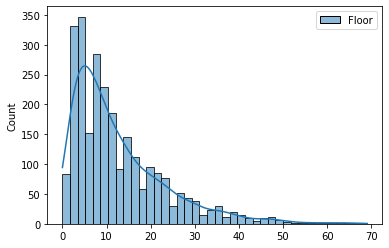

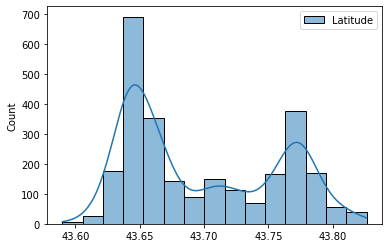

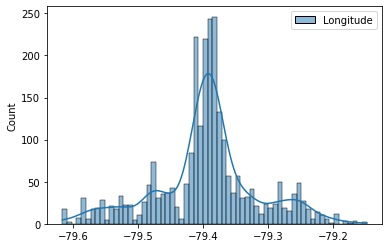

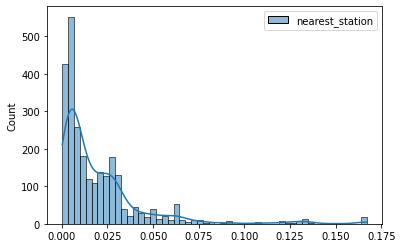

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.histplot(new_condos[['Floor']], kde=True)
plt.show()
sns.histplot(new_condos[['Latitude']], kde=True)
plt.show()
sns.histplot(new_condos[['Longitude']], kde=True)
plt.show()
sns.histplot(new_condos[['nearest_station']], kde=True)
plt.show()

Correlation heatmap of all variables

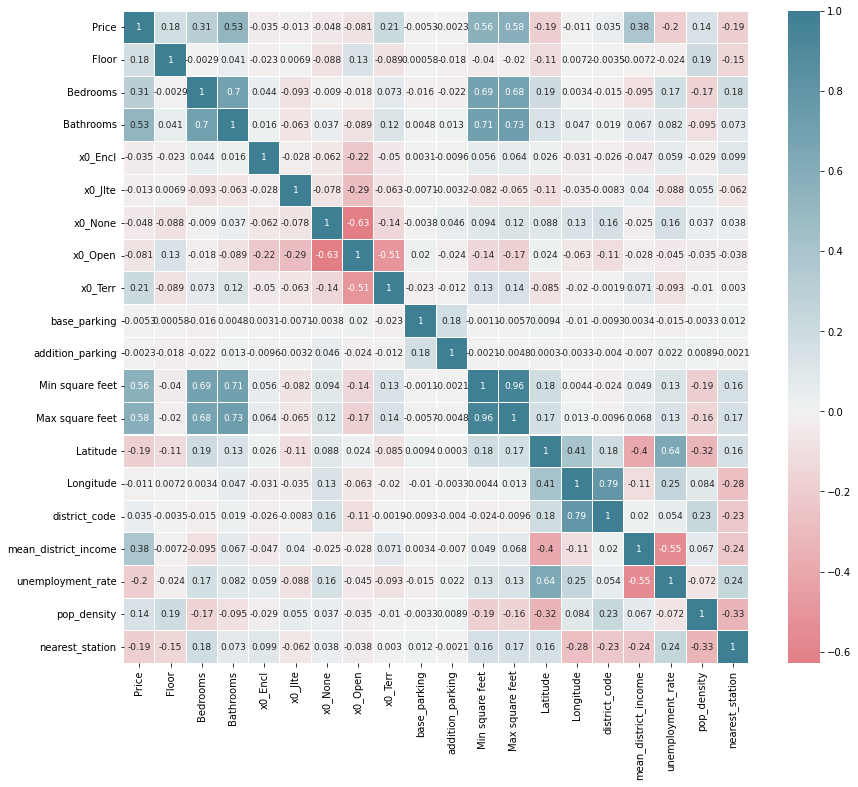

In [41]:
def correlation_heatmap(df, center = None):
    fig, ax = plt.subplots(figsize = [14,12])
    colormap = sns.diverging_palette(10, 220, as_cmap=True)
    fig = sns.heatmap(df.corr(),
                cmap = colormap,
               center = center,
                annot = True,
                linewidths = 0.1,
                annot_kws={'fontsize':9})
    
    
correlation_heatmap(new_condos, center=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x0_Encl  2617 non-null   float64
 1   x0_None  2617 non-null   float64
 2   x0_Open  2617 non-null   float64
 3   x0_Terr  2617 non-null   float64
 4   0        2617 non-null   float64
 5   1        2617 non-null   float64
 6   2        2617 non-null   float64
 7   5        2617 non-null   float64
 8   6        2617 non-null   float64
 9   7        2617 non-null   float64
 10  8        2617 non-null   float64
 11  9        2617 non-null   float64
 12  10       2617 non-null   float64
 13  11       2617 non-null   float64
 14  12       2617 non-null   float64
dtypes: float64(15)
memory usage: 306.8 KB
None
MAE scores:
- ridge -132149.729 (10705.199) 0.559 (0.116)
- knn -88705.228 (9337.284) 0.680 (0.138)
- Decision Tree -99226.312 (16874.314) 0.497 (0.395)
- Lasso -132244.819 (10712.024) 0.559 (0.116)


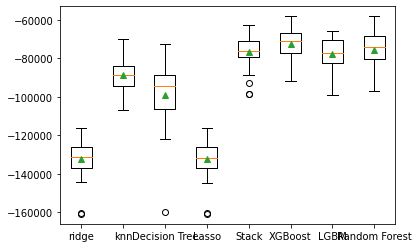

In [73]:
#Split into train/val/test
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor


from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import QuantileTransformer


from sklearn.preprocessing import KBinsDiscretizer  

rfr_best_params = {'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}

xgb_best_params = {'learning_rate': 0.01,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400}

lgbm_best_params = {'learning_rate': 0.01,
 'max_depth': 30,
 'max_features': 'auto',
 'n_estimators': 1336,
 'num_leaves': 10}

def get_stacking():
    # define the base models
    level0 = list()
    #level0.append(('lgbm', LGBMRegressor()))
    #level0.append(('rfr', RandomForestRegressor()))
    level0.append(('xgb', GradientBoostingRegressor()))
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('lbgm', LGBMRegressor()))
    # define meta learner model
    level1 = Ridge(alpha=1.0)
    #level1 = DecisionTreeRegressor()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    r2 = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores, r2


def transform_data(df):
    cols = [col for col in df.columns if col not in ['Price', 'city_district']]
    X = df[cols]
    #X = condos.loc[:, condos.columns != 'Price'].to_numpy()
    y = df['Price'].to_numpy() 
    

    #Transform the data into a more Gaussian shape
    columns = ['x0_Encl','x0_Jlte','x0_None','x0_Open','x0_Terr','Longitude'
              ]
    power = PowerTransformer(method='yeo-johnson')
    quantile_transformer = QuantileTransformer(
        output_distribution='normal', random_state=0)

    sc = StandardScaler()
    pipeline = Pipeline(steps=[('p', power)])
    cols = [col for col in X.columns if col not in columns]
    X_data = X[cols]
    X_data = pd.DataFrame(pipeline.fit_transform(X_data))
    
    

    X_old = X[columns]
    X = pd.concat([X_old, X_data], axis=1)
    
    #Feature selection
    
    selector = SelectKBest(f_regression, k=15)
    selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    X = X.iloc[:,cols]
    print(X.info())
    
    return X, y

X, y = transform_data(new_condos)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)
ridge = Ridge(alpha=1.0)

#kNN
knn = KNeighborsRegressor()

#Decision tree regressor
dt = DecisionTreeRegressor()


#Lasso regression
lassoReg = linear_model.Lasso(alpha=0.1)

#Random forest
rfr = RandomForestRegressor(**rfr_best_params)


stack = get_stacking()

lgb = LGBMRegressor()


xgb = GradientBoostingRegressor(**xgb_best_params)


models = {'ridge': ridge, 'knn': knn, 'Decision Tree': dt, 'Lasso': lassoReg, 'Stack': stack, 'XGBoost': xgb, 
          'LGBM': lgb, 'Random Forest': rfr}
results, names = [], []
print("MAE scores:")
for name, model in models.items():
	 scores, r2 = evaluate_model(model, X, y)
	 results.append(scores)
	 names.append(name)
	 print('- %s %.3f (%.3f) %.3f (%.3f)' % (name, mean(scores), std(scores), mean(r2), std(r2)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Hyperparameter Grid Search

In [46]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [47]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=10, random_state=42, n_jobs = -1)


rf_random.fit(X, y)
#Evaluate

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  5

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [48]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}

In [50]:
scores = evaluate_model(rf_random.best_estimator_, X, y)	
print('%.3f (%.3f)' % (mean(scores[0]), std(scores[0])))

-75164.475 (9401.422)


In [51]:
print(mean(scores[1]))

0.7567492787141651


In [52]:
#search xgboost

# Define our search space for grid search
xgb_space = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

xgb = GradientBoostingRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = xgb_space, n_iter = 50, cv = 3, verbose=10, random_state=42, n_jobs = -1)


xgb_random.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 15

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [53]:
xgb_random.best_params_

{'learning_rate': 0.01,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400}

In [59]:
scores = evaluate_model(xgb_random.best_estimator_, X, y)	
print('%.3f (%.3f)' % (mean(scores[0]), std(scores[0])))

-72483.805 (9115.913)


In [68]:
#search lgbmboost

# Define our search space for grid search
lgbm_space = {
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [int(x) for x in np.linspace(0, 110, num = 11)],
    'num_leaves': [int(x) for x in np.linspace(10, 110, num = 50)],
    'max_features': ['auto', 'sqrt']
}

lgbm = LGBMRegressor()
lgbm_random = RandomizedSearchCV(estimator = lgbm, param_distributions = lgbm_space, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1)


lgbm_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.187

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                         

In [69]:
lgbm_random.best_params_

{'learning_rate': 0.1,
 'max_depth': 77,
 'max_features': 'sqrt',
 'n_estimators': 60,
 'num_leaves': 58}

In [70]:
scores = evaluate_model(lgbm_random.best_estimator_, X, y)	
print('%.3f (%.3f)' % (mean(scores[0]), std(scores[0])))

-77540.674 (9016.066)
